# installations and imports


In [ ]:
!pip install TensorFlow
!pip3 install torch torchvision

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch as pt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Data Cleaning + Plotting

In [ ]:
data = pd.read_csv("/content/HistoricalData_apple_max.csv")

In [ ]:
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,07/03/2023,$192.46,31346600,$193.78,$193.88,$191.76
1,06/30/2023,$193.97,85213220,$191.63,$194.48,$191.26
2,06/29/2023,$189.59,46347310,$189.08,$190.07,$188.94
3,06/28/2023,$189.25,51216800,$187.93,$189.90,$187.60
4,06/27/2023,$188.06,50730850,$185.89,$188.39,$185.67


In [ ]:
data["Date"] = pd.to_datetime(data["Date"])
data["day"] = data['Date'].map(lambda x: x.day)
data["month"] = data['Date'].map(lambda x: x.month)
data["year"] = data['Date'].map(lambda x: x.year)

In [ ]:
data.head()

,Date,Close/Last,Volume,Open,High,Low,day,month,year
0,2023-07-03,$192.46,31346600,$193.78,$193.88,$191.76,3,7,2023
1,2023-06-30,$193.97,85213220,$191.63,$194.48,$191.26,30,6,2023
2,2023-06-29,$189.59,46347310,$189.08,$190.07,$188.94,29,6,2023
3,2023-06-28,$189.25,51216800,$187.93,$189.90,$187.60,28,6,2023
4,2023-06-27,$188.06,50730850,$185.89,$188.39,$185.67,27,6,2023


In [ ]:
data["rounded_open"] = (data["Open"].str[1:]).astype(float)
data["rounded_close"] = (data["Close/Last"].str[1:]).astype(float).astype(int)
data["rounded_high"] = (data["High"].str[1:]).astype(float).astype(int)
data["rounded_low"] = (data["Low"].str[1:]).astype(float).astype(int)

In [ ]:
data["diff"] = (data["High"].str[1:]).astype(float) - (data["Low"].str[1:]).astype(float)

In [ ]:
data.head()

,Date,Close/Last,Volume,Open,High,Low,day,month,year,rounded_open,rounded_close,rounded_high,rounded_low,diff
0,2023-07-03,$192.46,31346600,$193.78,$193.88,$191.76,3,7,2023,193.78,192,193,191,2.12
1,2023-06-30,$193.97,85213220,$191.63,$194.48,$191.26,30,6,2023,191.63,193,194,191,3.22
2,2023-06-29,$189.59,46347310,$189.08,$190.07,$188.94,29,6,2023,189.08,189,190,188,1.13
3,2023-06-28,$189.25,51216800,$187.93,$189.90,$187.60,28,6,2023,187.93,189,189,187,2.30
4,2023-06-27,$188.06,50730850,$185.89,$188.39,$185.67,27,6,2023,185.89,188,188,185,2.72


Text(0.5, 1.0, 'Daiily Apple stock volume')

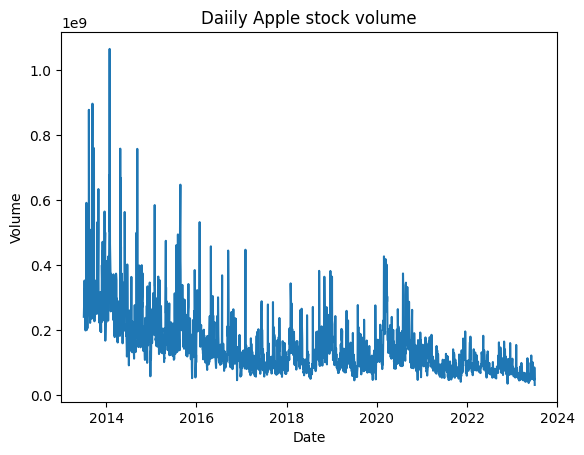

In [ ]:
plt.plot(data["Date"], data["Volume"])
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Daiily Apple stock volume")

Text(0.5, 1.0, 'Daiily Apple stock price')

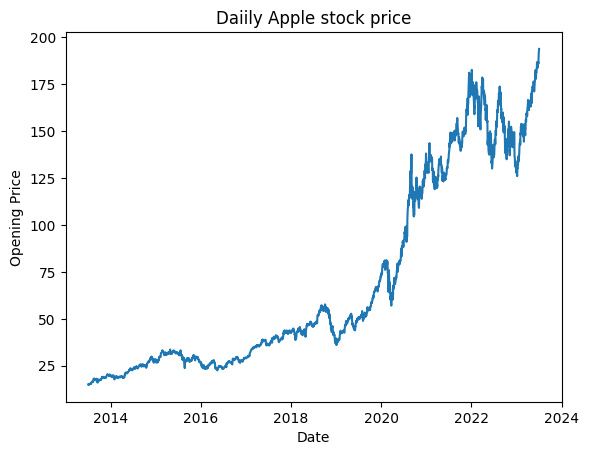

In [ ]:
plt.plot(data["Date"], data["rounded_open"])
plt.xlabel("Date")
plt.ylabel("Opening Price")
plt.title("Daiily Apple stock price")

Text(0.5, 1.0, 'Daiily Apple stock price')

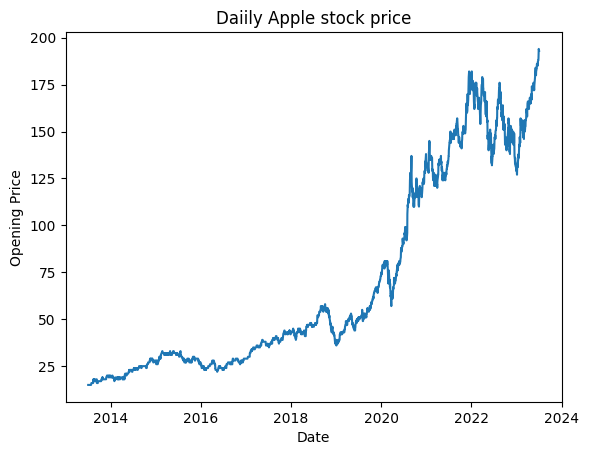

In [ ]:
plt.plot(data["Date"], data["rounded_high"])
plt.xlabel("Date")
plt.ylabel("Opening Price")
plt.title("Daiily Apple stock price")

Text(0.5, 1.0, 'Daiily Apple stock high/low dif')

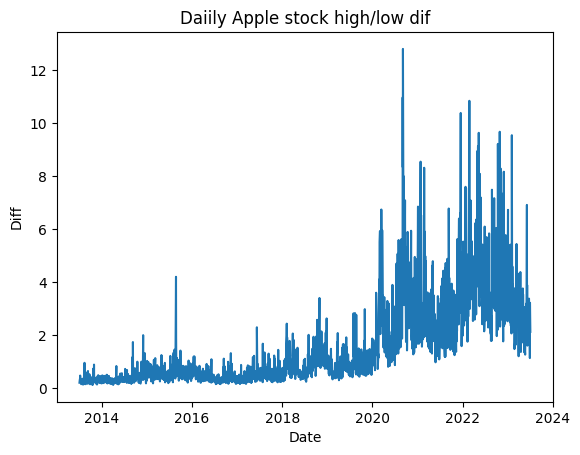

In [ ]:
plt.plot(data["Date"], data["diff"])
plt.xlabel("Date")
plt.ylabel("Diff")
plt.title("Daiily Apple stock high/low dif")

# Now we go on to actually predicting stock prices

# Train-Test Split
First we'll split the data into train and test data sets. The fraction used in splitting is sort of abritrary so im just gonna choose 80%. So the first 80% of entries in our origional data set become our training set and the last 20% become our validation set. Usually a dataset is split into train and test and then the train is further split into 2 to get the training data and validation data. In our case the test data is going to be the days after our dataset ends.



In [ ]:
def split(data):
  cutoff = 0.8
  train_size = int(len(data) * cutoff)
  train = data[:train_size][['Date', 'rounded_open']]
  val = data[train_size:][['Date', 'rounded_open']]
  return train, val

In [ ]:
train, val = split(data)
train_data = train.rounded_open.values.reshape(-1,1)
train_data.shape

you usually want to scale your numerical data for various reasons such as numerical stability, faster convergence and having a fair influence by each feature. By scaling features we can have faster convergence as the algorithm will be able to traverse the weight space more efficiently. Since we commonly use activation functions like the sigmoid or tanh, both of which could suffer from the dreaded vanishing gradient problem if the scale of the features is too big. If the feature values are too big then the net might give those features more value than the other features which is something we might not want.

Since we plan on using a gradient based algorithm (eg. SGD or adam) and beecause of the other benefits mentioned above we should scale the data. Commonly used are MinMaxScaler and StandardScaler.


In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))
train_scaled = scaler.fit_transform(train_data)
train_scaled

array([[1.        ],
       [0.98744745],
       [0.97255955],
       ...,
       [0.05032695],
       [0.05238498],
       [0.05099837]])

Now we generate the sequeneced data (i.e chuncked by time)
example: X_train[0] is the first 50 stock price values and Y_train[0] is the stock price on the 51st day. X_train[1] is the day 1 to 51 stock price values and y_train[1] is the stock price on the 52nd day and so on. Basically the X_train[i] has the last timestep number of values that we use as data and then y_train[i] is the target value for the day after.

In [ ]:
X_train = []
y_train = []

time_step = 50
train_size = len(train_scaled)
for i in range(time_step, train_size):
    X_train.append(train_scaled[i-time_step:i,0])
    y_train.append(train_scaled[i,0])

# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train before reshape : (1963, 50)
Shape of y_train before reshape : (1963,)


In [ ]:
X_train[0]

array([[1.        ],
       [0.98744745],
       [0.97255955],
       [0.9658454 ],
       [0.95393508],
       [0.95942317],
       [0.95195002],
       [0.94138253],
       [0.94815507],
       [0.94529426],
       [0.95883933],
       [0.94266698],
       [0.93922233],
       [0.93589444],
       [0.9269617 ],
       [0.92830453],
       [0.90725712],
       [0.91043905],
       [0.9193426 ],
       [0.93490191],
       [0.92556049],
       [0.90611864],
       [0.90392924],
       [0.90179823],
       [0.88054647],
       [0.87523354],
       [0.86752686],
       [0.87943718],
       [0.88439981],
       [0.89847034],
       [0.87867819],
       [0.87114666],
       [0.87278141],
       [0.87961233],
       [0.88229799],
       [0.88364082],
       [0.87879496],
       [0.87897011],
       [0.87564222],
       [0.86685544],
       [0.83132882],
       [0.85824381],
       [0.86168846],
       [0.85695936],
       [0.85234703],
       [0.83308034],
       [0.82061537],
       [0.833

3
3756


In [ ]:
y_train[0]

array([0.83833489])

# Creating the model architecture


## Vanilla RNN

Now we go on to construct a basic rnn model using keras! We first initialize the empty model by using Sequential( ), we then add the rnn layers using SimpleRNN. The units parameter is how many units or neurons you want in that layer. The activation parameter is for choosing the activation function which in standard rnns is commonly tanh. return_sequences = True , makes it so the layer outputs all the intermidiate values calculated at each timestep instead of just outputting the final value. The input shape in the first layer is (X_train.shape[1], 1) which is a 50 x 1 vector which contains the stock prices for each "window" (i.e its the first sequence of values). I use 4 rnn layers here but this too is a hyperparameter, just like the number of units in each layer.

We also use Dropout as a regularization method to prevent overfitting to the data. Dropout takes in a number in [0, 1] (in our case 0.2) and thats the chance that a neuron is "switched off". This does NOT mean that each step 20% of the neurons are switched off but that eeach neuron independently has a 20% chance of being switched off. So in exopectation about 20% will be turned off each step. This is again another hyperparameter that can be adjusted to try to achieve the desired results.

At the end we then have a fully connected layer with only one unit (since we only need 1 ouput, i.e the predicted stock price). We then pick our adam as ourr gradieent based optimizer, MSE as the loss and accuracy as our metric and then train/fit the model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

#initializing the Recurrent Neural Net
rnn = Sequential()

#adding the first layer
rnn.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1],1)))
rnn.add(Dropout(0.2))

#adding the second layer
rnn.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
rnn.add(Dropout(0.2))

#adding the third layer
rnn.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
rnn.add(Dropout(0.2))

#adding the fourth layer
rnn.add(SimpleRNN(units = 50))
rnn.add(Dropout(0.2))

#add output layer
rnn.add((Dense(units=1)))

#choose all the replacable pieces you want to use for training and validation
rnn.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["accuracy"])

#train the model
history = rnn.fit(X_train, y_train, epochs = 50, batch_size = 32)


Here we plot the loss vs epochs to see how our loss changes

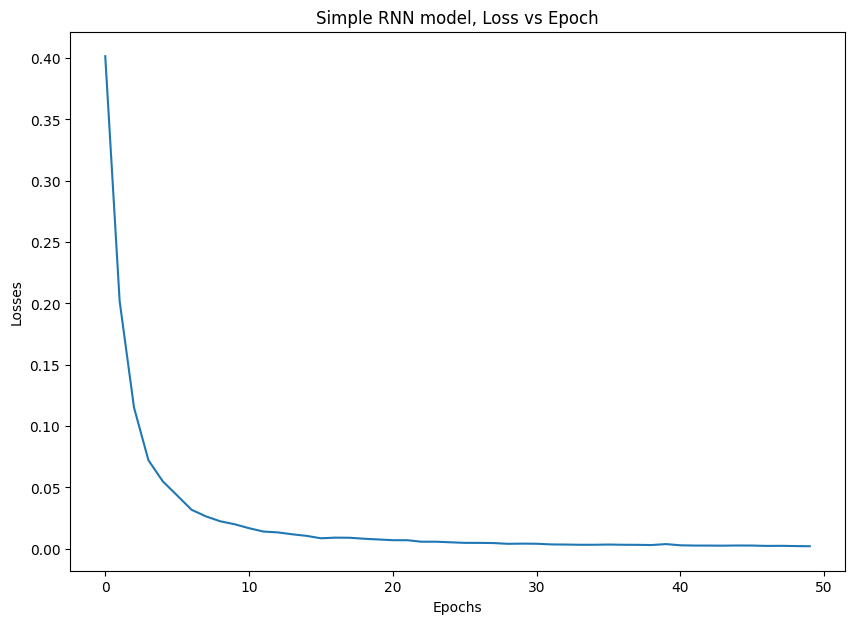

In [ ]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

In [ ]:
y_pred = rnn.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original

We need to do this because of how our initial data set was constructed. The Dates were decreasing as we go down the rows, which is thee opposite of what we want in our plot, so wee just flip our values.

In [ ]:
y_pred = y_pred[::-1]
y_train = y_train[::-1]

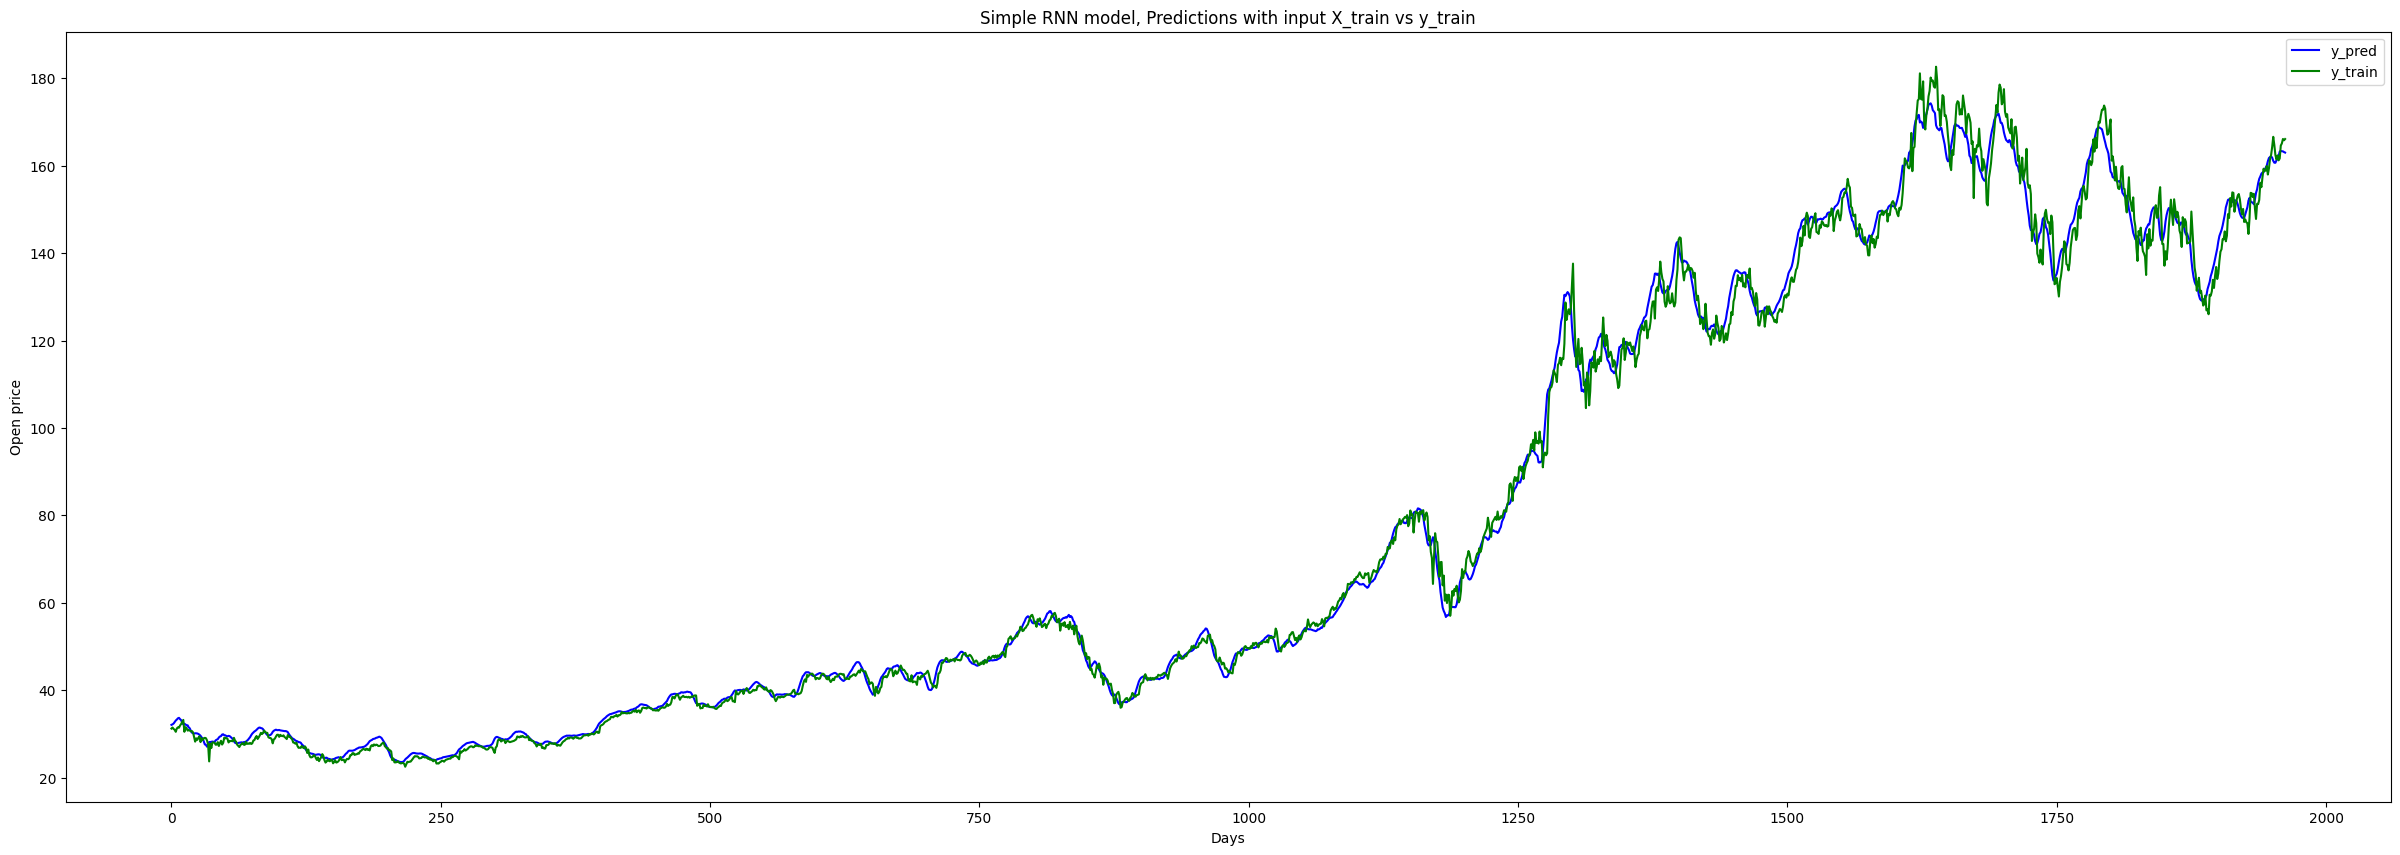

In [ ]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [ ]:
val_data = val.rounded_open.values.reshape(-1,1)
scaled_dataset_validation =  scaler.fit_transform(val_data)
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

Shape of scaled validation dataset : (504, 1)


In [ ]:
# Creating X_test and y_test
X_test = []
y_test = []
len_val = len(val)
for i in range(time_step, len_val):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)

print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
y_test = np.reshape(y_test, (-1,1))

print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

Shape of X_test before reshape : (454, 50)
Shape of y_test before reshape : (454,)
Shape of X_test after reshape : (454, 50, 1)
Shape of y_test after reshape : (454, 1)


In [ ]:
# predictions with X_test data
y_pred_of_test = rnn.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test)
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

15/15 [==============================] - 1s 37ms/step
Shape of y_pred_of_test : (454, 1)


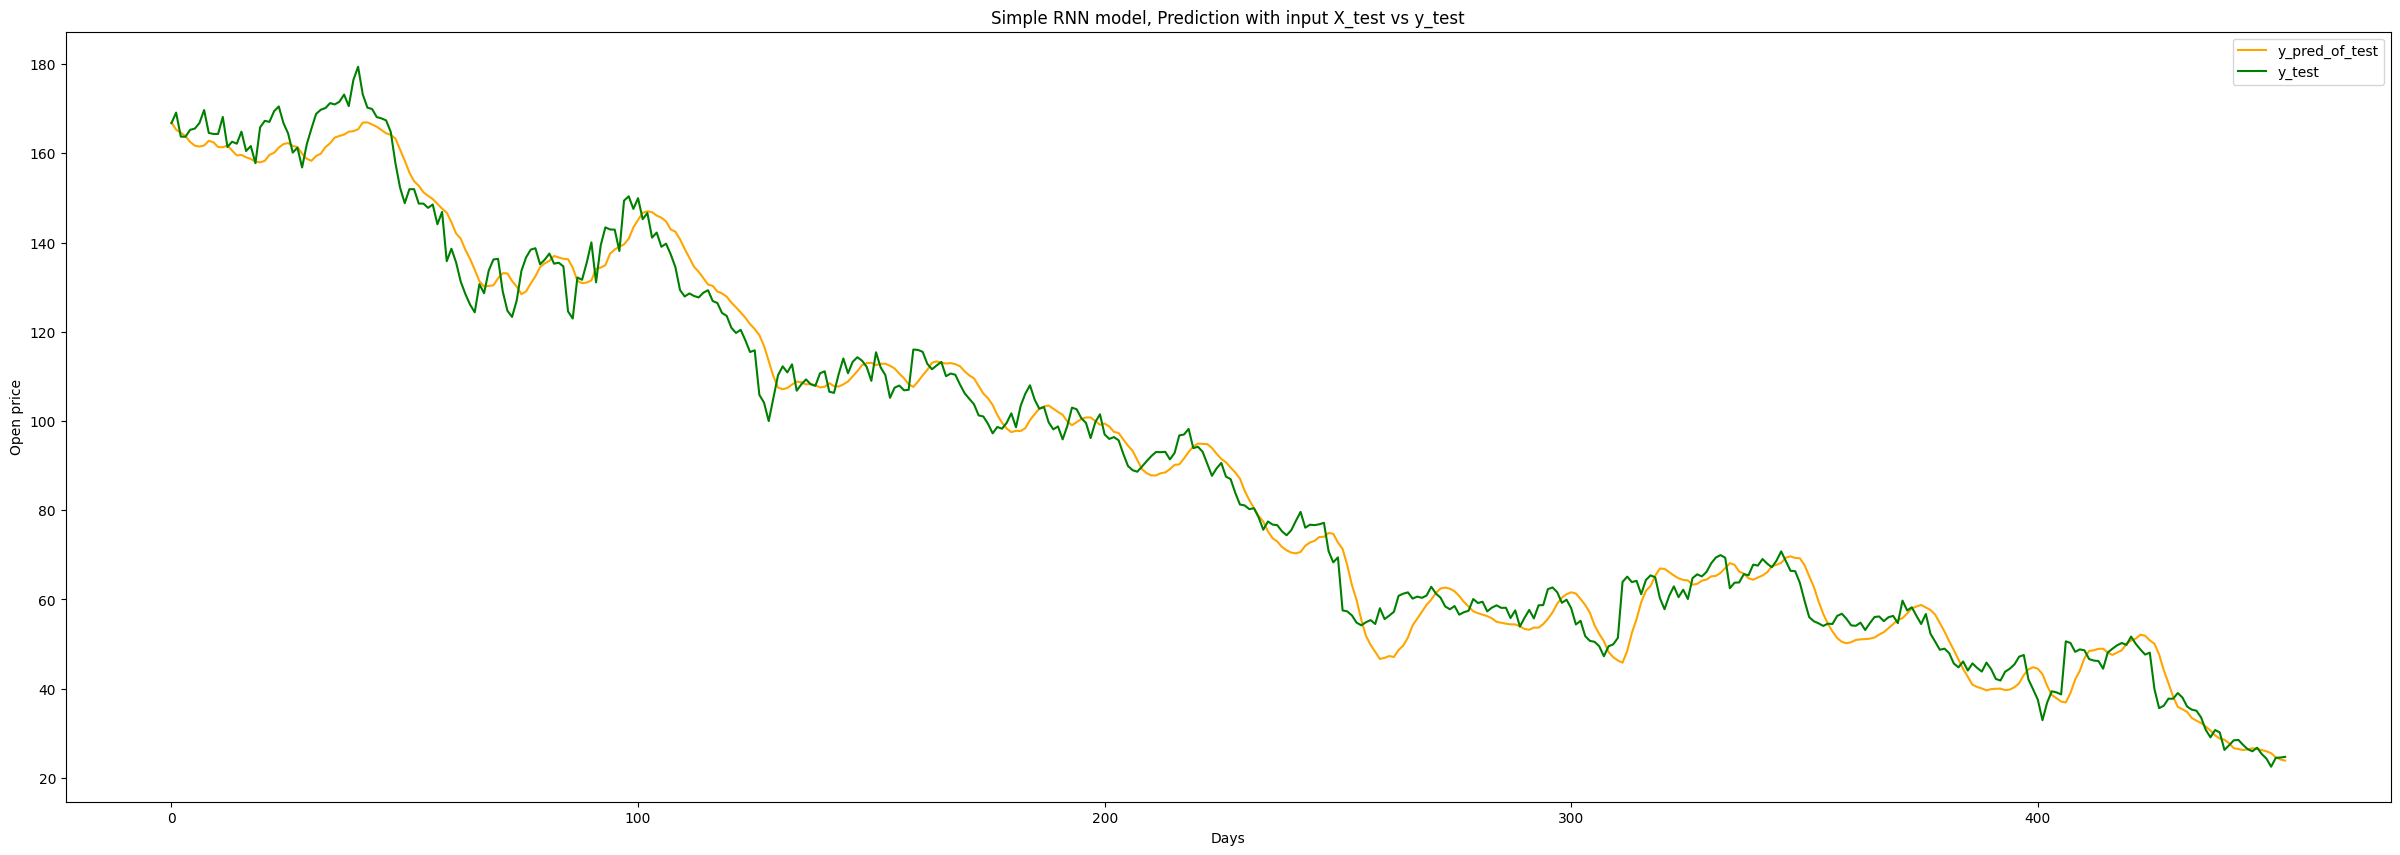

In [ ]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

##LSTM

In [ ]:
#redo the scaling we undid for the vanilla rnn
y_train = scaler.fit_transform(y_train)

In [ ]:
from keras.layers import LSTM

#initializing the lstm model
lstm = Sequential()

#add the first layer with 32 neurons/units
lstm.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))

#add the second layer with 32 neurons/units
lstm.add(LSTM(64, return_sequences=True))

#add first fully connected layer
lstm.add(Dense(units=32))

#add second fully connected/output layer
lstm.add(Dense(units=1))

#choose all the replacable pieces you want to use for training and validation
lstm.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["accuracy"])

#train/fit the model
lstm_history = lstm.fit(X_train, y_train, epochs = 10, batch_size = 10)

Epoch 1/10
197/197 [==============================] - 16s 62ms/step - loss: 0.0363 - accuracy: 9.5772e-04
Epoch 2/10
197/197 [==============================] - 14s 69ms/step - loss: 0.0162 - accuracy: 9.9847e-04
Epoch 3/10
197/197 [==============================] - 12s 62ms/step - loss: 0.0137 - accuracy: 0.0010
Epoch 4/10
197/197 [==============================] - 13s 67ms/step - loss: 0.0119 - accuracy: 0.0010
Epoch 5/10
197/197 [==============================] - 15s 78ms/step - loss: 0.0109 - accuracy: 0.0010
Epoch 6/10
197/197 [==============================] - 14s 71ms/step - loss: 0.0106 - accuracy: 0.0010
Epoch 7/10
197/197 [==============================] - 12s 62ms/step - loss: 0.0102 - accuracy: 0.0010
Epoch 8/10
197/197 [==============================] - 12s 62ms/step - loss: 0.0098 - accuracy: 0.0010
Epoch 9/10
197/197 [==============================] - 12s 62ms/step - loss: 0.0096 - accuracy: 0.0010
Epoch 10/10
197/197 [==============================] - 12s 62ms/step - los